## Objective
Notation:
1. Here, w=0.2 would mean that it is weak. 
2. w=0.8 would mean that it is strong.

In [27]:
import sys
sys.path.append('..')

from data.split_dataset import _load_data_channelwise_fpath_hagen as load_hagen_raw
import numpy as np
import matplotlib.pyplot as plt


In [50]:
import os
from skimage.io import imread


def load_tiff(path):
    """
    Returns a 4d numpy array: num_imgs*h*w*num_channels
    """
    data = imread(path, plugin='tifffile')
    return data

# def load_hagen_gt():
#     gt_data = load_hagen_raw(['/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
#                         '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'])
#     ch1 = np.stack(gt_data[0])
#     ch2 = np.stack(gt_data[1])
#     data = np.concatenate([ch1[...,None], ch2[...,None]], axis=-1)
#     return data

def load_predictions_raw(direc):
    bt_removed = load_tiff(os.path.join(direc,'bt_removed_pred.tif'))
    dim_pred = load_tiff(os.path.join(direc, 'dim_pred.tif'))
    return bt_removed, dim_pred

def load_predictions_indisplit(rootdir, modelpath, mixing_t_ood):
    "Hagen/MitoVsAct/LeanLC/"
    fpath = os.path.join(rootdir,'predictions','_'.join(modelpath.split('/')), f'T-{mixing_t_ood}_MMSE-10_InferT-1_InferTAgg-1_FixedT-None')
    bt_removed, dim_pred = load_predictions_raw(fpath)
    return {str(min(mixing_t_ood, 1-mixing_t_ood)): dim_pred, str(max(mixing_t_ood, 1-mixing_t_ood)): bt_removed}, fpath

def load_predictions_indi(rootdir, modelpath, mixing_t_ood):
    "Hagen/MitoVsAct/LeanLC/"
    fpath = os.path.join(rootdir,'predictions','_'.join(modelpath.split('/')), f'T-{mixing_t_ood}_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.5')
    bt_removed, dim_pred = load_predictions_raw(fpath)
    return {str(min(mixing_t_ood, 1-mixing_t_ood)): dim_pred, str(max(mixing_t_ood, 1-mixing_t_ood)): bt_removed}, fpath

def load_input_tar(rootdir, indisplit_modelpath, mixing_t_ood):
    """
    /group/jug/ashesh/indiSplit/predictions/2502_Hagen-joint_indi-l1_57/InpVsTar_T-0.1/
    """
    direc = os.path.join(rootdir, 'predictions', '_'.join(indisplit_modelpath.split('/')), f'InpVsTar_T-{mixing_t_ood}')
    inp = load_tiff(os.path.join(direc, 'input.tif'))
    tar = load_tiff(os.path.join(direc, 'target.tif'))
    return {str(min(mixing_t_ood, 1-mixing_t_ood)): inp[...,1], str(max(mixing_t_ood, 1-mixing_t_ood)): inp[...,0], 'tar':tar}, direc

def load_predictions_denoisplit(rootdir, modelpath, mixing_t_ood):
    """
    /group/jug/ashesh/indiSplit/prediction_baselines/denoiSplit_2502_D7-M3-S0-L0_7_T-0.1_MMSE-10/pred.tif
    """
    smaller_w = min(mixing_t_ood, 1-mixing_t_ood)
    larger_w = max(mixing_t_ood, 1-mixing_t_ood)
    model_str = '_'.join(modelpath.split('/'))
    fpath_schema = os.path.join(rootdir, 'prediction_baselines', 'denoiSplit_{model_str}_T-{w}_MMSE-10', 'pred.tif')
    smaller_w_data = load_tiff(fpath_schema.format(w=smaller_w, model_str=model_str))
    larger_w_data = load_tiff(fpath_schema.format(w=larger_w, model_str=model_str))
    bt_removed = np.concatenate([larger_w_data[...,:1], smaller_w_data[...,1:]], axis=-1)
    dim_pred = np.concatenate([smaller_w_data[...,:1], larger_w_data[...,1:]], axis=-1)
    return {str(smaller_w): dim_pred, str(larger_w): bt_removed}, fpath_schema.format(w=smaller_w, model_str=model_str)

def load_predictions_usplit_unet(rootdir, modelpath, mixing_t_ood):
    """
    /group/jug/ashesh/indiSplit/prediction_baselines/uSplit_2502_D13-M3-S0-L0_6_T-0.1_MMSE-10/pred.tif
    """
    smaller_w = min(mixing_t_ood, 1-mixing_t_ood)
    larger_w = max(mixing_t_ood, 1-mixing_t_ood)
    model_str = '_'.join(modelpath.split('/'))
    fpath_schema = os.path.join(rootdir, 'prediction_baselines', 'uSplit_{model_str}_T-{w}_MMSE-10', 'pred.tif')
    smaller_w_data = load_tiff(fpath_schema.format(w=smaller_w, model_str=model_str))
    larger_w_data = load_tiff(fpath_schema.format(w=larger_w, model_str=model_str))
    bt_removed = np.concatenate([larger_w_data[...,:1], smaller_w_data[...,1:]], axis=-1)
    dim_pred = np.concatenate([smaller_w_data[...,:1], larger_w_data[...,1:]], axis=-1)
    return {str(smaller_w): dim_pred, str(larger_w): bt_removed}, fpath_schema.format(w=smaller_w, model_str=model_str)

In [67]:
import os

rootdir = '/group/jug/ashesh/indiSplit'
mixing_t_ood = 0.2
assert mixing_t_ood in [0.1, 0.2, 0.3, 0.4, 0.5]

dset = 'biosr'
model_subdirs = {
    'hagen':{
        'unet': '2211/D7-M10-S0-L3/1',
        'indi': '2502/Hagen-joint_indi-l1/58',
        'indisplit': '2502/Hagen-joint_indi-l1/57',
        'denoisplit': '2502/D7-M3-S0-L0/7',
        'leanlc': 'Hagen/MitoVsAct/LeanLC/',
        'regularlc': '2210/D7-M3-S0-L0/78',
        'deeplc': 'Hagen/MitoVsAct/DeepLC/'
    },
    'biosr':{
        'unet':"2502/D13-M10-S0-L3/1",
        'indi':"2502/BioSR-joint_indi-l1/6",
        'indisplit':"2502/BioSR-joint_indi-l1/5",
        'denoisplit':"2502/D16-M3-S0-L0/5",
        'leanlc':"2502/D13-M3-S0-L0/6",
        'regularlc':"2502/D13-M3-S0-L0/9",
        'deeplc':"2502/D13-M3-S0-L0/8"
    }
}
inp,_ = load_input_tar(rootdir, model_subdirs[dset]['indisplit'], mixing_t_ood)
tar = inp['tar']

unet_data, unet_fpaths = load_predictions_usplit_unet(rootdir, model_subdirs[dset]['unet'], mixing_t_ood)
indi_data, indi_fpaths = load_predictions_indi(rootdir, model_subdirs[dset]['indi'], mixing_t_ood)
indisplit_data, indisplit_fpaths = load_predictions_indisplit(rootdir, model_subdirs[dset]['indisplit'], mixing_t_ood)#load_predictions(os.path.join(rootdir,'predictions','_'.join(model_subdirs[dset]['indisplit'].split('/')), f'T-{mixing_t_ood}_MMSE-10_InferT-1_InferTAgg-1_FixedT-None'))
denoiSplit_data, denoisplit_fpaths = load_predictions_denoisplit(rootdir, model_subdirs[dset]['denoisplit'], mixing_t_ood)
leanlc_data, leanlc_fpaths = load_predictions_usplit_unet(rootdir, model_subdirs[dset]['leanlc'], mixing_t_ood)
regularlc_data, regularlc_fpaths = load_predictions_usplit_unet(rootdir, model_subdirs[dset]['regularlc'], mixing_t_ood)
deeplc_data, deeplc_fpaths = load_predictions_usplit_unet(rootdir, model_subdirs[dset]['deeplc'], mixing_t_ood)


# reordering the channels
if dset =='biosr':
    denoiSplit_0 = denoiSplit_data[str(mixing_t_ood)][..., [1,0]]
    denoiSplit_1 = denoiSplit_data[str(1-mixing_t_ood)][..., [1,0]]
    denoiSplit_data = {str(mixing_t_ood): denoiSplit_0, str(1-mixing_t_ood): denoiSplit_1}

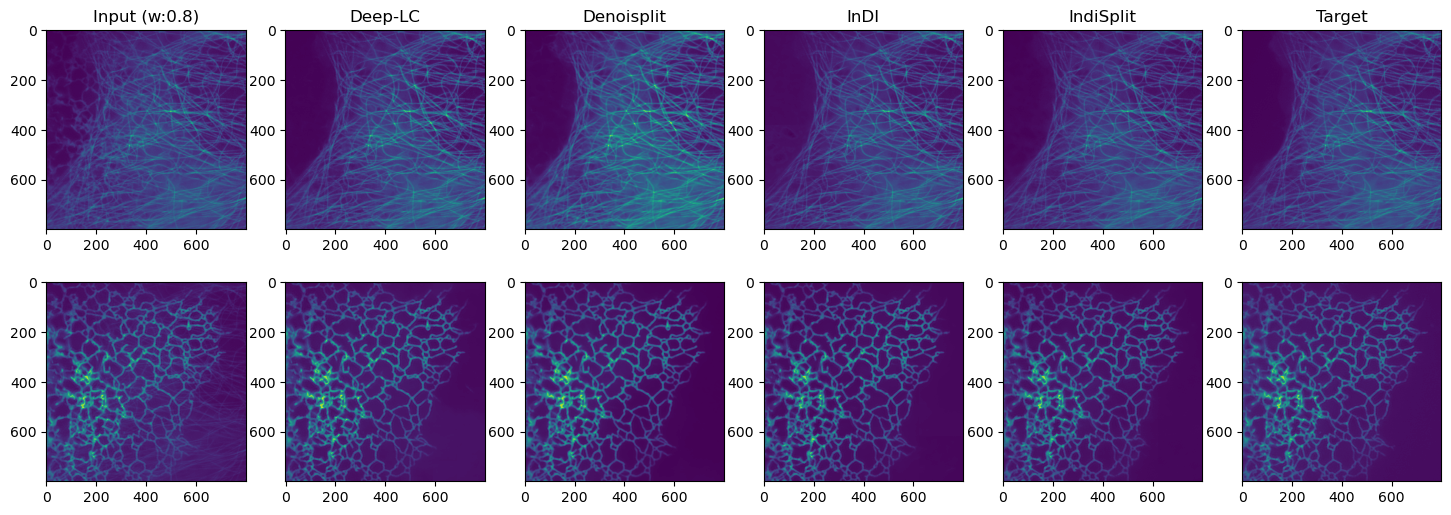

In [69]:
import matplotlib.pyplot as plt

mode = 'bt_removal'
assert mode in ['bt_removal', 'dim_pred']
if mode == 'bt_removal':
    use_t = str(1-mixing_t_ood)
else:
    use_t = str(mixing_t_ood)

unused_t = f'{1-float(use_t):.1f}'

hs = 0
ws = 0
sz = 800
img_idx = 0
# inp, deepLC, denoiSplit, inDI, indiSplit, tar
_,ax = plt.subplots(figsize=(18,6),ncols=6,nrows=2)
ax[0,0].set_title('Input (w:{})'.format(use_t))
ax[0,0].imshow(inp[use_t][img_idx,hs:hs+sz,ws:ws+sz])
ax[1,0].imshow(inp[unused_t][img_idx,hs:hs+sz,ws:ws+sz])

ax[0,1].set_title('Deep-LC')
ax[0,1].imshow(deeplc_data[use_t][img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,1].imshow(deeplc_data[use_t][img_idx,hs:hs+sz,ws:ws+sz,1])

ax[0,2].set_title('Denoisplit')
ax[0,2].imshow(denoiSplit_data[use_t][img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,2].imshow(denoiSplit_data[use_t][img_idx,hs:hs+sz,ws:ws+sz,1])

ax[0,3].set_title('InDI')
ax[0,3].imshow(indi_data[use_t][img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,3].imshow(indi_data[use_t][img_idx,hs:hs+sz,ws:ws+sz,1])

ax[0,4].set_title('IndiSplit')
ax[0,4].imshow(indisplit_data[use_t][img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,4].imshow(indisplit_data[use_t][img_idx,hs:hs+sz,ws:ws+sz,1])

ax[0,5].set_title('Target')
ax[0,5].imshow(tar[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,5].imshow(tar[img_idx,hs:hs+sz,ws:ws+sz,1])
